# Recreation of accepted solution from Challenge on LINE 1003.02

In [1]:
import torch
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import random

import magnav

In [2]:
print(f'PyTorch version : {torch.__version__}, Version used for dev : 1.9.0+cu102')

PyTorch version : 1.9.0+cu102, Version used for dev : 1.9.0+cu102


In [3]:
torch.manual_seed(27) # For reproducibility
random.seed(27)
np.random.seed(27)
torch.cuda.manual_seed(27)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# 0 - Load Solution Dataset

In [5]:
df = pd.read_hdf('../data/interim/Sol_dataset.h5', key=f'Flt1003')

In [6]:
df.head()

,FLUXB_TOT,FLUXB_X,FLUXC_TOT,FLUXC_Y,FLUXD_Y,FLUXD_Z,TL_comp_mag3_sq,UNCOMPMAG3,TL_comp_mag4_sq,TL_comp_mag5_sq,V_CABT,LINE,IGRFMAG1
Time [s],,,,,,,,,,,,,
49820.0,52836.179,40991.107,56629.409,-24121.629,-22136.973,10486.244,-770.948052,53000.806,-1837.427211,-132.727664,26.210,1003.01,-183.066
49820.1,52834.254,40995.387,56629.059,-24107.552,-22123.009,10491.522,-761.257336,53011.817,-1837.994231,-131.784263,26.169,1003.01,-183.522
49820.2,52832.980,41000.448,56627.953,-24095.028,-22109.401,10497.816,-757.416996,53016.958,-1838.356508,-129.755380,26.022,1003.01,-183.957
49820.3,52832.305,41006.539,56626.660,-24084.577,-22097.326,10505.743,-759.437211,53016.190,-1838.998602,-127.464817,25.839,1003.01,-184.368
49820.4,52832.223,41013.213,56625.663,-24076.470,-22088.167,10515.313,-765.931913,53010.724,-1839.819941,-125.954372,25.731,1003.01,-184.759


In [7]:
df_100302 = df.loc[df.LINE==1003.02].drop(columns='LINE').copy()
df_100308 = df.loc[df.LINE==1003.08].drop(columns='LINE').copy()
df_100304 = df.loc[df.LINE==1003.04].drop(columns='LINE').copy()

df_100302

,FLUXB_TOT,FLUXB_X,FLUXC_TOT,FLUXC_Y,FLUXD_Y,FLUXD_Z,TL_comp_mag3_sq,UNCOMPMAG3,TL_comp_mag4_sq,TL_comp_mag5_sq,V_CABT,IGRFMAG1
Time [s],,,,,,,,,,,,
50713.0,52809.731,45836.527,57309.322,-20373.009,-17985.210,16380.877,-950.772376,53523.946,-2071.372550,-61.063570,25.764,-87.226
50713.1,52811.018,45820.851,57306.630,-20424.408,-18037.225,16357.652,-948.311424,53523.221,-2070.150151,-61.193859,25.848,-86.141
50713.2,52812.682,45813.903,57305.748,-20462.687,-18075.506,16349.904,-945.399256,53523.888,-2068.744456,-60.430321,25.972,-85.007
50713.3,52814.429,45811.527,57306.206,-20490.384,-18102.921,16349.999,-942.605337,53525.144,-2067.344488,-59.631363,26.139,-83.824
50713.4,52816.019,45809.846,57307.524,-20510.464,-18122.788,16350.580,-940.197260,53526.096,-2066.215693,-58.782155,26.333,-82.591
...,...,...,...,...,...,...,...,...,...,...,...,...
54496.6,51280.093,28121.512,54972.514,12335.581,14158.832,-4215.732,-1560.060677,51709.089,-2320.139926,-83.070425,25.953,-438.465
54496.7,51273.877,28018.915,54956.556,12293.129,14111.604,-4362.922,-1560.836504,51698.779,-2319.699847,-82.679340,25.810,-439.180
54496.8,51267.495,27921.771,54942.245,12243.237,14057.119,-4507.320,-1562.138123,51688.472,-2320.161158,-82.361229,25.665,-439.882


# 1 - Preprocessing

## 1.1 - Low pass filter

This filter comes from Matlab lowpass filter (This are the coefficients extracted from Matlab)

In [8]:
num = [0.00013485,0.00014468,7.8213e-05,-0.00010382,-0.00043744,-0.00094761,-0.0016395,-0.0024902,-0.0034418,-0.0043974,
        -0.005221,-0.0057423,-0.0057668,-0.0050899,-0.003516,-0.00087932,0.0029351,0.007972,0.014191,0.021457,0.029541,0.03813,
        0.046838,0.055236,0.062881,0.069347,0.074263,0.077335,0.078381,0.077335,0.074263,0.069347,0.062881,0.055236,0.046838,
        0.03813,0.029541,0.021457,0.014191,0.007972,0.0029351,-0.00087932,-0.003516,-0.0050899,-0.0057668,-0.0057423,-0.005221,
        -0.0043974,-0.0034418,-0.0024902,-0.0016395,-0.00094761,-0.00043744,-0.00010382,7.8213e-05,0.00014468,0.00013485]
den = 1

sos = signal.tf2sos(num,den)

In [9]:
def apply_lowpass_filter(df,nb_filt=1):
    
    for n in range(nb_filt):
        df['FLUXB_TOT']  = signal.sosfiltfilt(sos,df['FLUXB_TOT'])
        df['FLUXB_X']    = signal.sosfiltfilt(sos,df['FLUXB_X'])
        df['FLUXC_TOT']  = signal.sosfiltfilt(sos,df['FLUXC_TOT'])
        df['FLUXC_Y']    = signal.sosfiltfilt(sos,df['FLUXC_Y'])
        df['FLUXD_Y']    = signal.sosfiltfilt(sos,df['FLUXD_Y'])
        df['FLUXD_Z']    = signal.sosfiltfilt(sos,df['FLUXD_Z'])
        df['UNCOMPMAG3'] = signal.sosfiltfilt(sos,df['UNCOMPMAG3'])
        df['V_CABT']     = signal.sosfiltfilt(sos,df['V_CABT'])


In [10]:
apply_lowpass_filter(df_100302,10)
apply_lowpass_filter(df_100308,10)
apply_lowpass_filter(df_100304,10)
df_100302

,FLUXB_TOT,FLUXB_X,FLUXC_TOT,FLUXC_Y,FLUXD_Y,FLUXD_Z,TL_comp_mag3_sq,UNCOMPMAG3,TL_comp_mag4_sq,TL_comp_mag5_sq,V_CABT,IGRFMAG1
Time [s],,,,,,,,,,,,
50713.0,52812.377887,45838.824381,57312.194412,-20374.030120,-17986.111440,16381.698029,-950.772376,53526.628684,-2071.372550,-61.063570,25.765291,-87.226
50713.1,52812.209715,45820.234772,57310.523152,-20377.377628,-17990.577489,16345.361373,-948.311424,53524.443828,-2070.150151,-61.193859,25.783319,-86.141
50713.2,52812.041407,45801.657678,57308.850509,-20380.582877,-17994.901554,16309.022223,-945.399256,53522.265896,-2068.744456,-60.430321,25.801266,-85.007
50713.3,52811.872828,45783.105217,57307.175082,-20383.505365,-17998.943421,16272.677679,-942.605337,53520.101715,-2067.344488,-59.631363,25.819054,-83.824
50713.4,52811.703849,45764.588734,57305.495444,-20386.008083,-18002.566390,16236.324058,-940.197260,53517.957917,-2066.215693,-58.782155,25.836604,-82.591
...,...,...,...,...,...,...,...,...,...,...,...,...
54496.6,51265.495920,27846.463412,54937.374140,12182.022554,13992.842644,-4643.050357,-1560.060677,51685.356262,-2320.139926,-83.070425,25.573827,-438.465
54496.7,51263.756760,27825.088167,54933.639176,12171.475786,13981.234917,-4672.193079,-1560.836504,51682.298063,-2319.699847,-82.679340,25.564349,-439.180
54496.8,51261.979771,27802.843644,54929.794384,12160.926812,13969.590478,-4702.407181,-1562.138123,51679.159910,-2320.161158,-82.361229,25.554736,-439.882


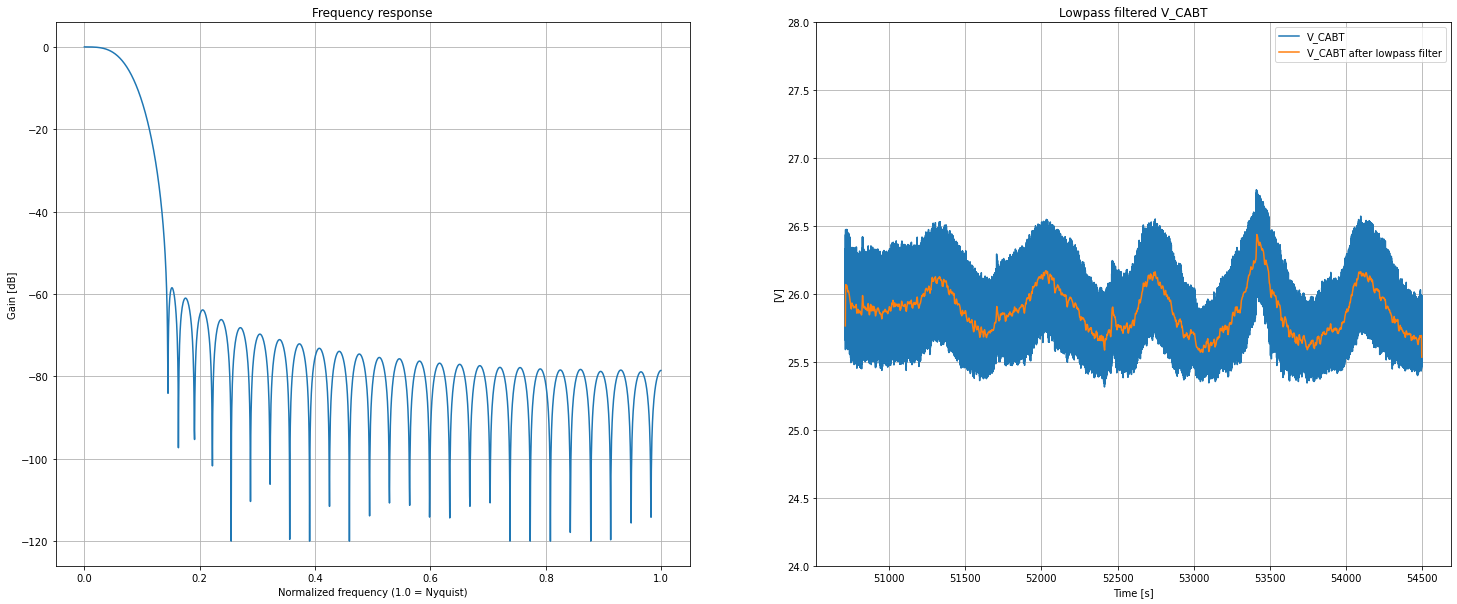

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[25,10])

w, h = signal.sosfreqz(sos, worN=2000)
db = 20*np.log10(np.maximum(np.abs(h),1e-6))

ax1.plot(w/np.pi,db)

ax1.grid()
ax1.set_xlabel('Normalized frequency (1.0 = Nyquist)')
ax1.set_ylabel('Gain [dB]')
ax1.set_title('Frequency response')

ax2.plot(df['V_CABT'].loc[df.LINE==1003.02],label='V_CABT')
ax2.plot(df_100302['V_CABT'],label='V_CABT after lowpass filter')

ax2.grid()
ax2.legend()
ax2.set_ylim([24,28])
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('[V]')
ax2.set_title('Lowpass filtered V_CABT')
plt.show()

## 1.2 - Standardization

<font size="5">
$z = \frac{x-\mu}{\sigma}$
</font>

Transformation to a standard normal distribution

In [12]:
df_100302.describe()

,FLUXB_TOT,FLUXB_X,FLUXC_TOT,FLUXC_Y,FLUXD_Y,FLUXD_Z,TL_comp_mag3_sq,UNCOMPMAG3,TL_comp_mag4_sq,TL_comp_mag5_sq,V_CABT,IGRFMAG1
count,37841.000000,37841.000000,37841.000000,37841.000000,37841.000000,37841.000000,37841.000000,37841.000000,37841.000000,37841.000000,37841.000000,37841.000000
mean,52055.113330,34656.967996,55904.737307,-4206.570424,-2212.805151,2813.457027,-1065.170845,52539.617152,-2036.760176,81.695182,25.879117,-104.676101
std,670.697640,9440.505271,1253.123183,15372.316338,15254.850644,12421.255188,407.377417,1053.488246,289.256902,252.100210,0.166503,325.684628
min,50784.779295,9380.192806,52688.265378,-24982.216366,-23486.435203,-25240.605140,-1891.256991,50770.597780,-2634.540280,-442.579019,25.535280,-680.184000
25%,51418.967663,24609.064458,54718.763906,-21962.662972,-19880.545035,-9616.139009,-1371.599528,51735.979911,-2233.795350,-61.715423,25.736496,-361.810000
50%,52050.998107,38111.206089,55977.215748,5163.424047,7125.927122,5052.462448,-1096.780281,52342.070002,-2053.765106,45.176277,25.873660,-132.838000
75%,52546.663304,41497.904711,56808.408812,8914.585038,10668.399936,10453.093531,-842.536501,52938.204114,-1912.488491,193.753231,25.997474,74.806000
max,54533.963827,53944.939463,59406.221012,17309.271986,19625.926908,41105.819965,1035.187651,56437.331997,-633.493655,1213.583753,26.437590,1592.592000


In [13]:
def apply_standardization(df):
    
    scaler = StandardScaler()
    scaler.fit(df)
    df[df.columns] = scaler.transform(df[df.columns])
    
    y_mean = scaler.mean_[-1]
    y_std = np.sqrt((scaler.var_[-1]))
    
    return y_mean,y_std

In [14]:
y100302_mean, y100302_std = apply_standardization(df_100302)
y100308_mean, y100308_std = apply_standardization(df_100308)
y100304_mean, y100304_std = apply_standardization(df_100304)

In [15]:
df_100302.describe()

,FLUXB_TOT,FLUXB_X,FLUXC_TOT,FLUXC_Y,FLUXD_Y,FLUXD_Z,TL_comp_mag3_sq,UNCOMPMAG3,TL_comp_mag4_sq,TL_comp_mag5_sq,V_CABT,IGRFMAG1
count,3.784100e+04,3.784100e+04,3.784100e+04,37841.000000,37841.000000,3.784100e+04,3.784100e+04,3.784100e+04,3.784100e+04,3.784100e+04,3.784100e+04,3.784100e+04
mean,3.196607e-15,4.927101e-16,-2.163117e-16,0.000000,0.000000,-4.806927e-17,1.051515e-17,4.350269e-15,-5.347707e-16,4.206061e-17,-3.905629e-15,-1.201732e-17
std,1.000013e+00,1.000013e+00,1.000013e+00,1.000013,1.000013,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00
min,-1.894074e+00,-2.677517e+00,-2.566798e+00,-1.351515,-1.394567,-2.258583e+00,-2.027842e+00,-1.679224e+00,-2.066633e+00,-2.079654e+00,-2.065079e+00,-1.767094e+00
25%,-9.484961e-01,-1.064354e+00,-9.464266e-01,-1.155085,-1.158187,-1.000685e+00,-7.522084e-01,-7.628446e-01,-6.811861e-01,-5.688710e-01,-8.565751e-01,-7.895285e-01
50%,-6.135817e-03,3.659003e-01,5.783901e-02,0.609545,0.612189,1.802584e-01,-7.759354e-02,-1.875197e-01,-5.878911e-02,-1.448606e-01,-3.277504e-02,-8.647099e-02
75%,7.329032e-01,7.246463e-01,7.211449e-01,0.853569,0.844412,6.150536e-01,5.465136e-01,3.783547e-01,4.296296e-01,4.445039e-01,7.108535e-01,5.510990e-01
max,3.695977e+00,2.043135e+00,2.794242e+00,1.399667,1.431612,3.082850e+00,5.155873e+00,3.699867e+00,4.851345e+00,4.489895e+00,3.354185e+00,5.211454e+00


## 1.3 - Time Frame

Input : $[t_{-2}, t_{-1}, t_{0}, t_{+1}, t_{+2}]$

Model generate an output for $t_{0}$

In [16]:
def create_Xy(df):
    
    t_0 = df.index[2]
    t_end = df.index[-3]
    
    y = df[['IGRFMAG1']].copy()
    df = df.drop(columns='IGRFMAG1')
    y = y.drop(index=[y.index[0],y.index[1],y.index[-2],y.index[-1]])
    
    idx = df.drop(index=[df.index[0],df.index[1],df.index[-1],df.index[-2]]).index
    
    X = pd.concat([df.drop(index=[df.index[-1],df.index[-2],df.index[-3],df.index[-4]]).set_index(idx),
                   df.drop(index=[df.index[0],df.index[-1],df.index[-2],df.index[-3]]).set_index(idx),
                   df.drop(index=[df.index[0],df.index[1],df.index[-1],df.index[-2]]),
                   df.drop(index=[df.index[0],df.index[1],df.index[2],df.index[-1]]).set_index(idx),
                   df.drop(index=[df.index[0],df.index[1],df.index[2],df.index[3]]).set_index(idx)
               ],axis=1)
    
    return X,y

In [17]:
X100302, y100302 = create_Xy(df_100302)
X100308, y100308 = create_Xy(df_100308)
X100304, y100304 = create_Xy(df_100304)

Each 11 columns is shifted of 0.1s to get the new time frame with the start index time shifted of 0.2s and index end time shifted of -0.2s.

## 1.4 - Train and Validation set

Train = 4/5, Validation = 1/5

In [18]:
batch = 64

In [19]:
device = magnav.get_device()
#device = 'cpu'

Currently using cuda


In [20]:
def df_to_torch(X):
    X = torch.from_numpy(X.to_numpy()).float().to(device)
    return X

In [21]:
print('Before',type(X100302))
X100302 = df_to_torch(X100302)
print('After',type(X100302))

y100302 = df_to_torch(y100302)

X100308 = df_to_torch(X100308)
y100308 = df_to_torch(y100308)

X100304 = df_to_torch(X100304)
y100304 = df_to_torch(y100304)

Before <class 'pandas.core.frame.DataFrame'>
After <class 'torch.Tensor'>


In [22]:
X100302_train, X100302_val, y100302_train, y100302_val = train_test_split(X100302,y100302,test_size=1/5,shuffle=False)
X100308_train, X100308_val, y100308_train, y100308_val = train_test_split(X100308,y100308,test_size=1/5,shuffle=False)

In [23]:
train100302_dataset = torch.utils.data.TensorDataset(X100302_train,y100302_train)
train100302_loader  = torch.utils.data.DataLoader(dataset=train100302_dataset,batch_size=batch,shuffle=False)

val100302_dataset   = torch.utils.data.TensorDataset(X100302_val,y100302_val)
val100302_loader    = torch.utils.data.DataLoader(dataset=val100302_dataset,batch_size=batch,shuffle=False)

train100308_dataset = torch.utils.data.TensorDataset(X100308_train,y100308_train)
train100308_loader  = torch.utils.data.DataLoader(dataset=train100308_dataset,batch_size=batch,shuffle=False)

val100308_dataset   = torch.utils.data.TensorDataset(X100308_val,y100308_val)
val100308_loader    = torch.utils.data.DataLoader(dataset=val100308_dataset,batch_size=batch,shuffle=False)

## 1.5 - Test concat dataset

In [24]:
Xconcat_train = torch.cat((X100302_train,X100308_train),0)
yconcat_train = torch.cat((y100302_train,y100308_train),0)

Xconcat_val = torch.cat((X100302_val,X100308_val),0)
yconcat_val = torch.cat((y100302_val,y100308_val),0)

In [25]:
trainconcat_dataset = torch.utils.data.TensorDataset(Xconcat_train,yconcat_train)
trainconcat_loader  = torch.utils.data.DataLoader(dataset=trainconcat_dataset,batch_size=batch,shuffle=False)

valconcat_dataset = torch.utils.data.TensorDataset(Xconcat_val,yconcat_val)
valconcat_loader  = torch.utils.data.DataLoader(dataset=valconcat_dataset,batch_size=batch,shuffle=False)

In [26]:
Xconcat_train

tensor([[ 1.1291,  1.1845,  1.1232,  ..., -0.1018, -0.5572, -0.2553],
        [ 1.1288,  1.1825,  1.1218,  ..., -0.1001, -0.5536, -0.1518],
        [ 1.1286,  1.1805,  1.1205,  ..., -0.0996, -0.5496, -0.0506],
        ...,
        [-0.5820, -1.0553, -1.0718,  ...,  1.0727,  1.1477,  0.5049],
        [-0.5761, -1.0428, -1.0612,  ...,  1.0709,  1.1386,  0.5111],
        [-0.5703, -1.0307, -1.0510,  ...,  1.0710,  1.1336,  0.5172]],
       device='cuda:0')

# 2 - MLP

## 2.1 - Model from scratch

### 2.2.1 - Architecture

In [27]:
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [28]:
class Chall_MLP(torch.nn.Module):
    
    def __init__(self):
        super(Chall_MLP, self).__init__()
        self.architecture = torch.nn.Sequential(
            torch.nn.Linear(55,50),
            torch.nn.Tanh(),
            torch.nn.Linear(50,30),
            torch.nn.Tanh(),
            torch.nn.Linear(30,10),
            torch.nn.Tanh(),
            torch.nn.Linear(10,1),
        )
        self.architecture.apply(init_weights)
        
        
    def forward(self, x):
        logits = self.architecture(x)
        return logits

In [29]:
model = Chall_MLP().to(device)
print(model)

Chall_MLP(
  (architecture): Sequential(
    (0): Linear(in_features=55, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=10, bias=True)
    (5): Tanh()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)


### 2.2.2 - Loss Function

This class ensure that during a backward pass, when you multiply 0 by $\infty$ (derivative of $\sqrt{0}$), the returned tensor will be 0 and not Nan

In [30]:
class RMSELoss(torch.nn.Module):
    
    def __init__(self):
        super(RMSELoss,self).__init__()
        
    def forward(self,yhat,y):
        criterion = torch.nn.MSELoss()
        loss = torch.sqrt(criterion(yhat,y)+1e-6)
        return loss 

In [31]:
criterion = RMSELoss()

### 2.2.3 - Optimizer

In [32]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3) 

In [33]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.9,patience=5,min_lr=1e-5)

### 2.2.4 - Training loop

In [34]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'runs/Chall_MLP_{timestamp}')

EPOCHS = 500

pbar = tqdm_notebook(total=EPOCHS,unit="epoch",desc='Training')

for epoch in range(EPOCHS):

    train_running_loss = 0.

    # Make sure gradient tracking is on, and do a pass over the data
    model.train()

    # Enumerate allow to track batch index and intra-epoch reporting 
    for i, (inputs, labels) in enumerate(trainconcat_loader):

        # Zero gradients for every batch
        optimizer.zero_grad()

        # Make prediction for this batch
        predictions = model(inputs)

        # Compute the loss and its gradients
        loss = criterion(predictions, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        train_running_loss += loss.detach().item() * inputs.size(0)
        

    avg_loss = train_running_loss/ len(trainconcat_loader.dataset)
    writer.add_scalar('training_loss',avg_loss,epoch)
    
    # Desactivate layers such as dropout or batch-normalization
    model.eval()

    val_running_loss = 0.0
    
    
    with torch.set_grad_enabled(False):
        for i, (vinputs, vlabels) in enumerate(valconcat_loader):

            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            val_running_loss += vloss.detach().item()* vinputs.size(0)

    avg_vloss = val_running_loss/len(valconcat_loader.dataset)
    
    scheduler.step(avg_vloss)
    
    writer.add_scalar('validation_loss',avg_vloss,epoch)
    
    pbar.set_postfix(train_loss=avg_loss,val_loss=avg_vloss,lr=optimizer.param_groups[0]['lr'])
    pbar.update()

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

In [34]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'runs/Chall_MLP_{timestamp}')

EPOCHS = 500

pbar = tqdm_notebook(total=EPOCHS,unit="epoch",desc='Training')

for epoch in range(EPOCHS):

    train_running_loss = 0.

    # Make sure gradient tracking is on, and do a pass over the data
    model.train()

    # Enumerate allow to track batch index and intra-epoch reporting 
    for i, (inputs, labels) in enumerate(trainconcat_loader):

        # Zero gradients for every batch
        optimizer.zero_grad()

        # Make prediction for this batch
        predictions = model(inputs)

        # Compute the loss and its gradients
        loss = criterion(predictions, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        train_running_loss += loss.detach().item() * inputs.size(0)
        

    avg_loss = train_running_loss/ len(trainconcat_loader.dataset)
    writer.add_scalar('training_loss',avg_loss,epoch)
    
    # Desactivate layers such as dropout or batch-normalization
    model.eval()

    val_running_loss = 0.0
    
    
    with torch.set_grad_enabled(False):
        for i, (vinputs, vlabels) in enumerate(valconcat_loader):

            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            val_running_loss += vloss.detach().item()* vinputs.size(0)

    avg_vloss = val_running_loss/len(valconcat_loader.dataset)
    
    scheduler.step(avg_vloss)
    
    writer.add_scalar('validation_loss',avg_vloss,epoch)
    
    pbar.set_postfix(train_loss=avg_loss,val_loss=avg_vloss,lr=optimizer.param_groups[0]['lr'])
    pbar.update()

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

# 3 - Predictions

1003.02 | 36.758873
1003.08 | 22.12498
1003.04 | 45.83724


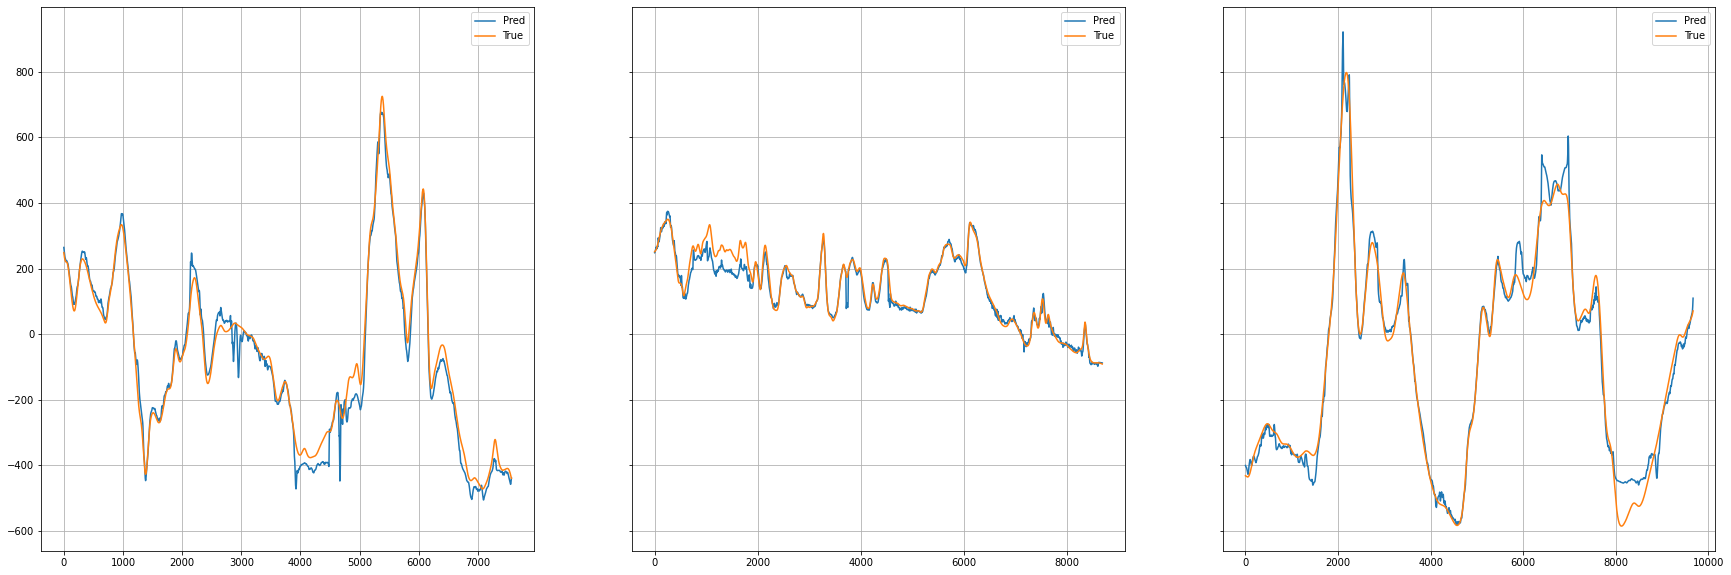

In [35]:
with torch.no_grad():
    
    pred = model(X100302_val)
    
    pred = (pred.cpu().detach().numpy()*y100302_std)+y100302_mean
    true = (y100302_val.cpu().detach().numpy()*y100302_std)+y100302_mean
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[30,10],sharey=True)
    ax1.plot(pred,label='Pred')
    ax1.plot(true,label='True')
    ax1.legend()
    ax1.grid()
    print('1003.02 |',magnav.rmse(pred,true))
    
    pred = model(X100308_val)

    pred = (pred.cpu().detach().numpy()*y100308_std)+y100308_mean
    true = (y100308_val.cpu().detach().numpy()*y100308_std)+y100308_mean
    
    ax2.plot(pred,label='Pred')
    ax2.plot(true,label='True')
    ax2.legend()
    ax2.grid()
    print('1003.08 |',magnav.rmse(pred,true))
    
    pred = model(X100304[int((4/5)*len(X100304)):])
    
    pred = (pred.cpu().detach().numpy()*y100304_std)+y100304_mean
    true = (y100304[int((4/5)*len(X100304)):].cpu().detach().numpy()*y100304_std)+y100304_mean
    
    ax3.plot(pred,label='Pred')
    ax3.plot(true,label='True')
    ax3.legend()
    ax3.grid()
    print('1003.04 |',magnav.rmse(pred,true))
    
    

# 4- Multiple MLP

In [36]:
def train_model(model_MLP):  
    
    criterion = RMSELoss()
    optimizer = torch.optim.Adam(model_MLP.parameters(),lr=1e-3) 
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.9,patience=5,min_lr=1e-5)
    
    EPOCHS = 500

    pbar = tqdm_notebook(total=EPOCHS,unit="epoch",desc='Training')

    for epoch in range(EPOCHS):

        train_running_loss = 0.

        # Make sure gradient tracking is on, and do a pass over the data
        model_MLP.train()

        # Enumerate allow to track batch index and intra-epoch reporting 
        for i, (inputs, labels) in enumerate(trainconcat_loader):

            # Zero gradients for every batch
            optimizer.zero_grad()

            # Make prediction for this batch
            predictions = model_MLP(inputs)

            # Compute the loss and its gradients
            loss = criterion(predictions, labels)
            loss.backward()

            # Adjust learning weights
            optimizer.step()

            # Gather data and report
            train_running_loss += loss.detach().item() * inputs.size(0)


        avg_loss = train_running_loss/ len(trainconcat_loader.dataset)
        writer.add_scalar('training_loss',avg_loss,epoch)

        # Desactivate layers such as dropout or batch-normalization
        model_MLP.eval()

        val_running_loss = 0.0


        with torch.set_grad_enabled(False):
            for i, (vinputs, vlabels) in enumerate(valconcat_loader):

                voutputs = model_MLP(vinputs)
                vloss = criterion(voutputs, vlabels)
                val_running_loss += vloss.detach().item()* vinputs.size(0)

        avg_vloss = val_running_loss/len(valconcat_loader.dataset)

        scheduler.step(avg_vloss)

        writer.add_scalar('validation_loss',avg_vloss,epoch)

        pbar.set_postfix(train_loss=avg_loss,val_loss=avg_vloss,lr=optimizer.param_groups[0]['lr'])
        pbar.update()

In [37]:
model2 = Chall_MLP().to(device)
model3 = Chall_MLP().to(device)
model4 = Chall_MLP().to(device)
model5 = Chall_MLP().to(device)
model6 = Chall_MLP().to(device)
model7 = Chall_MLP().to(device)
model8 = Chall_MLP().to(device)
model9 = Chall_MLP().to(device)
model10 = Chall_MLP().to(device)
model11 = Chall_MLP().to(device)
model12 = Chall_MLP().to(device)

train_model(model2)
train_model(model3)
train_model(model4)
train_model(model5)
train_model(model6)
train_model(model7)
train_model(model8)
train_model(model9)
train_model(model10)
train_model(model11)
train_model(model12)

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

1003.02 | 45.4377
1003.08 | 17.884035
1003.04 | 40.01184


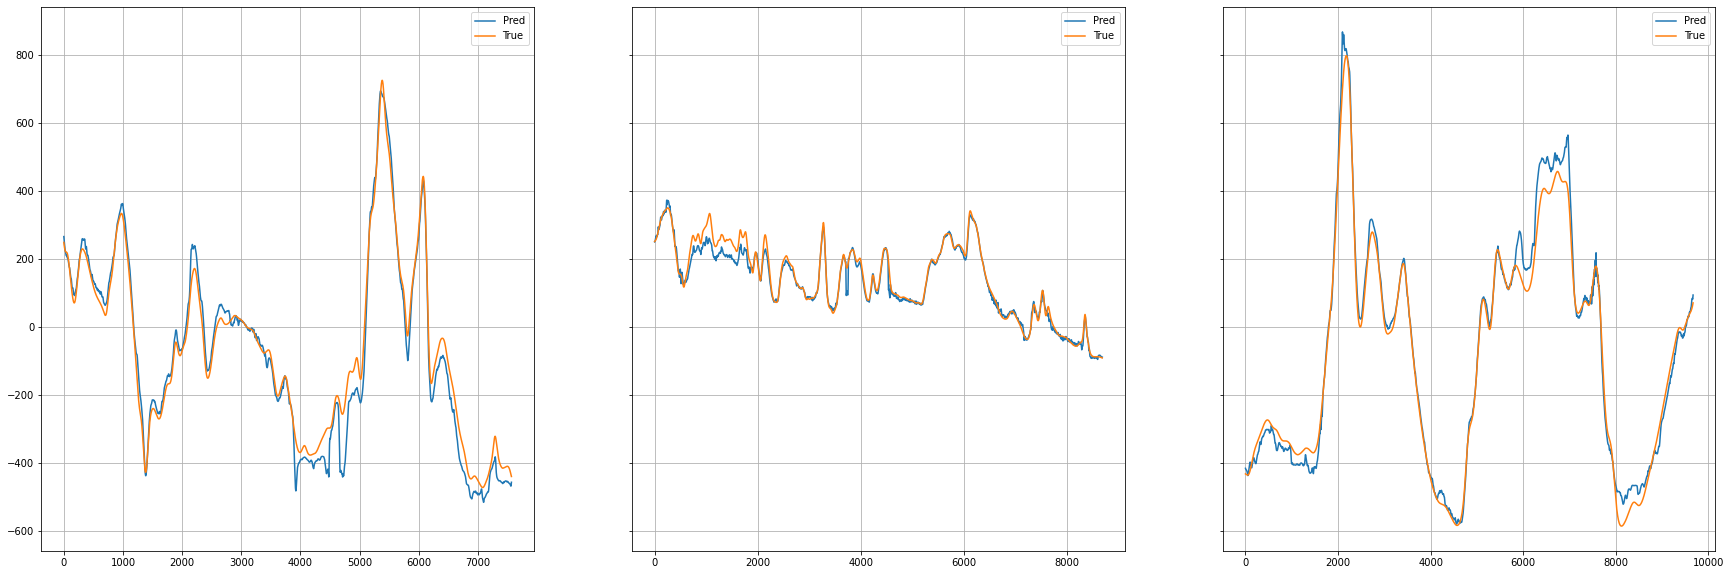

In [40]:
with torch.no_grad():
    
    pred1 = model(X100302_val)
    pred2 = model2(X100302_val)
    pred3 = model3(X100302_val)
    pred4 = model4(X100302_val)
    pred5 = model5(X100302_val)
    pred6 = model6(X100302_val)
    pred7 = model8(X100302_val)
    pred8 = model8(X100302_val)
    pred9 = model9(X100302_val)
    pred10 = model10(X100302_val)
    pred11 = model11(X100302_val)
    pred12 = model12(X100302_val)
    
    pred = (pred1+pred2+pred3+pred4+pred5+pred6+pred7+pred8+pred9+pred10+pred11+pred12)/12
    
    pred = (pred.cpu().detach().numpy()*y100302_std)+y100302_mean
    true = (y100302_val.cpu().detach().numpy()*y100302_std)+y100302_mean
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[30,10],sharey=True)
    ax1.plot(pred,label='Pred')
    ax1.plot(true,label='True')
    ax1.legend()
    ax1.grid()
    print('1003.02 |',magnav.rmse(pred,true))
    
    pred1 = model(X100308_val)
    pred2 = model2(X100308_val)
    pred3 = model3(X100308_val)
    pred4 = model4(X100308_val)
    pred5 = model5(X100308_val)
    pred6 = model6(X100308_val)
    pred7 = model8(X100308_val)
    pred8 = model8(X100308_val)
    pred9 = model9(X100308_val)
    pred10 = model10(X100308_val)
    pred11 = model11(X100308_val)
    pred12 = model12(X100308_val)
    
    pred = (pred1+pred2+pred3+pred4+pred5+pred6+pred7+pred8+pred9+pred10+pred11+pred12)/12

    pred = (pred.cpu().detach().numpy()*y100308_std)+y100308_mean
    true = (y100308_val.cpu().detach().numpy()*y100308_std)+y100308_mean
    
    ax2.plot(pred,label='Pred')
    ax2.plot(true,label='True')
    ax2.legend()
    ax2.grid()
    print('1003.08 |',magnav.rmse(pred,true))
    
    pred1 = model(X100304[int((4/5)*len(X100304)):])
    pred2 = model2(X100304[int((4/5)*len(X100304)):])
    pred3 = model3(X100304[int((4/5)*len(X100304)):])
    pred4 = model4(X100304[int((4/5)*len(X100304)):])
    pred5 = model5(X100304[int((4/5)*len(X100304)):])
    pred6 = model6(X100304[int((4/5)*len(X100304)):])
    pred7 = model8(X100304[int((4/5)*len(X100304)):])
    pred8 = model8(X100304[int((4/5)*len(X100304)):])
    pred9 = model9(X100304[int((4/5)*len(X100304)):])
    pred10 = model10(X100304[int((4/5)*len(X100304)):])
    pred11 = model11(X100304[int((4/5)*len(X100304)):])
    pred12 = model12(X100304[int((4/5)*len(X100304)):])
    
    pred = (pred1+pred2+pred3+pred4+pred5+pred6+pred7+pred8+pred9+pred10+pred11+pred12)/12
    
    pred = (pred.cpu().detach().numpy()*y100304_std)+y100304_mean
    true = (y100304[int((4/5)*len(X100304)):].cpu().detach().numpy()*y100304_std)+y100304_mean
    
    ax3.plot(pred,label='Pred')
    ax3.plot(true,label='True')
    ax3.legend()
    ax3.grid()
    print('1003.04 |',magnav.rmse(pred,true))